In [ ]:


!mkdir ~/.kaggle    #make a dir
!cp kaggle.json ~/.kaggle/   #cp file
!chmod 600 ~/.kaggle/kaggle.json #change permisssions
!ls ~/ -a #list all dirs in ~/

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
.   .bashrc  .config   .jupyter  .keras		.local	.profile    .wget-hsts
..  .cache   .ipython  .kaggle	 .launchpadlib	.npm	.tmux.conf


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload();

!mkdir ~/.kaggle    #make a dir
!cp kaggle.json ~/.kaggle/   #cp file
!chmod 600 ~/.kaggle/kaggle.json #change permisssions
!ls ~/ -a #list all dirs in ~/

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
.   .bashrc  .config   .jupyter  .keras		.local	.profile    .wget-hsts
..  .cache   .ipython  .kaggle	 .launchpadlib	.npm	.tmux.conf


# Natural Language Processing with Disaster Tweets

[Página en kaggle](https://www.kaggle.com/competitions/nlp-getting-started/overview)

## Librerias y datos

In [ ]:
!pip install transformers --upgrade
!pip install tensorflow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import F1Score
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers import Embedding, Dropout
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import text, sequence
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification,DataCollatorWithPadding,AutoModelForSequenceClassification,DistilBertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 162MB/s]
Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Datos

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df['keyword'].fillna('No keyword',inplace=True)
train_df['location'].fillna('No location',inplace=True)
test_df['keyword'].fillna('No keyword',inplace=True)
test_df['location'].fillna('No location',inplace=True)

all_df = pd.concat([train_df.loc[:,train_df.columns != 'target'], test_df])


In [ ]:
all_df.shape

(10876, 4)

In [ ]:
train_df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [ ]:
train_df.shape,test_df.shape

((7613, 5), (3263, 4))

In [ ]:
train_df[['text','target']]

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


# Analisis de las variables

En este problema es "sencillo", por ahora solo usaremos la variable "text". Como es texto no podemos hacer un análisis al uso, pero podemos ver como se distribuye aunque sea la longitud de los textos.

count    10876.000000
mean       101.358680
std         33.840687
min          5.000000
25%         78.000000
50%        108.000000
75%        134.000000
max        157.000000
Name: text, dtype: float64


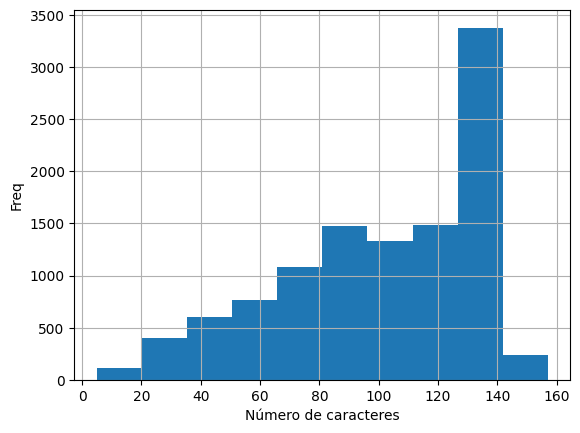

In [ ]:
print(all_df['text'].apply(lambda x: len(x)).describe())

plt.figure()
all_df['text'].apply(lambda x: len(x)).hist()
plt.ylabel("Freq")
plt.xlabel("Número de caracteres")
plt.show()

In [ ]:
train_df.groupby('target')['target'].count()

target
0    4342
1    3271
Name: target, dtype: int64

In [ ]:
max_text_len = 157

# Bert transformers y tensorflow

In [ ]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
def clean_text(text):
    text = text.lower()

    # quizás esto no sea necesario pero es buena práctica
    # quitamos todas las urls que pueda haber en los textos
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))

    # ahora quitamos todos los emoticonos
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticonos
                           u"\U0001F300-\U0001F5FF"  # simbolos & pictogramas
                           u"\U0001F680-\U0001F6FF"  # transportes y simbolos de maps
                           u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji.sub(r'', text)
    text = text.lower()

    #pasamos todo el texto de formas contraidas a extendidas
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text




def CleanTokenize(df,col):
    texts = list()
    lines = df[col].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenizamos (separamos en palabras) el texto ya limpio
        tokens = word_tokenize(line)
        # quitamos la puntuaciones
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # quitamos los posibles caracteres no alfabéticos
        words = [word for word in stripped if word.isalpha()]

        stop_words = set(stopwords.words("english"))
        # quitamos las stopwords
        words = [w for w in words if not w in stop_words]
        texts.append(words)
    return texts

In [ ]:
sentences = [' '.join(texto) for texto in CleanTokenize(train_df,'text')]
#sentences = list(train_df['text'])

train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, list(train_df['target']), test_size=0.3)

val_labels = [float(label) for label in val_labels]
train_labels = [float(label) for label in train_labels]

In [ ]:
frase = 'This is an example for the MiDS class'
print(f"Tokenizamos la frase '{frase}'")
tokens = tokenizer.tokenize(frase)
print(tokens)
ids = tokenizer.encode(frase,add_special_tokens=False)
print(ids)

Tokenizamos la frase 'This is an example for the MiDS class'
['this', 'is', 'an', 'example', 'for', 'the', 'mid', '##s', 'class']
[2023, 2003, 2019, 2742, 2005, 1996, 3054, 2015, 2465]


In [ ]:
# Tokenize the sentences
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_sentences, padding=True, truncation=True, return_tensors='tf', max_length = 50)
val_encodings = tokenizer(val_sentences, padding=True, truncation=True, return_tensors='tf', max_length = 50)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))

# Batch and shuffle the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Evaluate the model on the validation set
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
val_predictions = model.predict(val_dataset)
val_preds = tf.argmax(val_predictions.logits, axis=1)
val_accuracy = accuracy_score(val_labels, val_preds.numpy())
print(f"Validation Accuracy: {val_accuracy}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

72/72 [==============================] - 7s 42ms/step
Validation Accuracy: 0.42294220665499127


In [ ]:
# Load the pre-trained model
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
#model.layers[-1].activation = tf.keras.activations.sigmoid
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss =tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric_accu = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Mirar de calcular precision y recall y con eso sacar f1score

model.compile(optimizer=optimizer,
              loss=loss,
              #metrics=['acc',tf.keras.metrics.F1Score(average = "micro")]
              metrics = ['acc']
              )

# Train the model
epochs = 5 # Con dos parece que es suficiente.
epochs = 2
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose = 2)

# Evaluate the model on the validation set
val_predictions = model.predict(val_dataset)
val_preds = tf.argmax(val_predictions.logits, axis=1)
val_accuracy = accuracy_score(val_labels, val_preds.numpy())
print(f"Validation Accuracy: {val_accuracy}")

# Save the model
model_path = "modelo"
model.save_pretrained(model_path)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
167/167 - 53s - loss: 0.4814 - acc: 0.7784 - val_loss: 0.4172 - val_acc: 0.8192 - 53s/epoch - 317ms/step
Epoch 2/2
167/167 - 26s - loss: 0.3594 - acc: 0.8503 - val_loss: 0.3970 - val_acc: 0.8341 - 26s/epoch - 153ms/step
72/72 [==============================] - 5s 44ms/step
Validation Accuracy: 0.8340630472854641


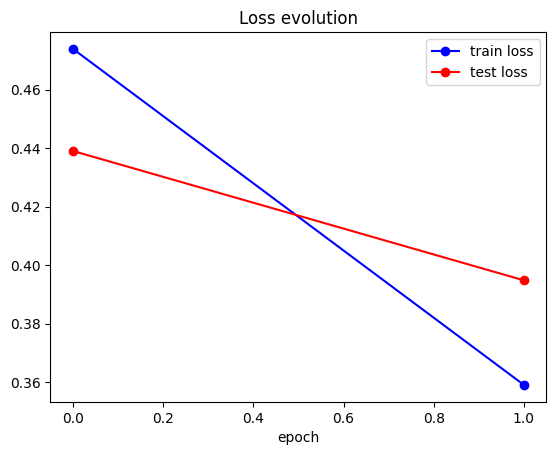

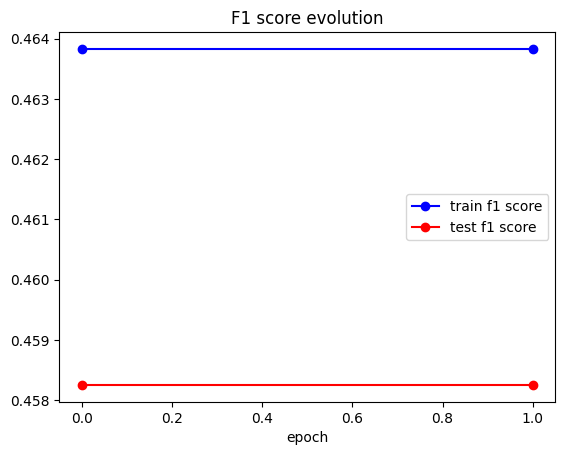

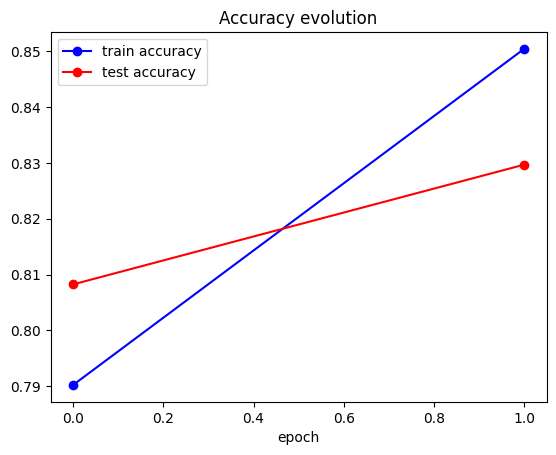

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acu = history.history['acc']
val_acu = history.history['val_acc']

f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

plt.figure()
plt.plot(history.epoch,loss, marker = 'o', color = 'b', label = "train loss")
plt.plot(history.epoch,val_loss, marker = 'o', color = 'r', label = "test loss")
plt.legend()
plt.title("Loss evolution")
plt.xlabel("epoch")
plt.savefig(model_path+"/loss.pdf")


plt.figure()
plt.plot(history.epoch,f1, marker = 'o', color = 'b', label = "train f1 score")
plt.plot(history.epoch,val_f1, marker = 'o', color = 'r', label = "test f1 score")
plt.legend()
plt.title("F1 score evolution")
plt.xlabel("epoch")
plt.savefig(model_path+"/f1_score.pdf")

plt.figure()
plt.plot(history.epoch,acu, marker = 'o', color = 'b', label = "train accuracy")
plt.plot(history.epoch,val_acu, marker = 'o', color = 'r', label = "test accuracy")
plt.legend()
plt.title("Accuracy evolution")
plt.xlabel("epoch")
plt.savefig(model_path+"/accuracy.pdf")

# Pruebas

In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf

# Load pre-trained BERT model and tokenizer
model_name = 'distilbert-base-uncased'
model = TFBertForSequenceClassification.from_pretrained(model_name)
model.layers[-1].units = 1
model.layers[-1].activation = tf.keras.activations.sigmoid
model.build(input_shape=(None, 50))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tf.keras.metrics.F1Score()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Tokenize the sentences
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
train_encodings = tokenizer(train_sentences, padding=True, truncation=True, return_tensors='tf', max_length = 50)
val_encodings = tokenizer(val_sentences, padding=True, truncation=True, return_tensors='tf', max_length = 50)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))

# Batch and shuffle the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Train the model
epochs = 2
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=2)


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.2.attention.k_lin.bias', 'distilbert.transformer.layer.5.attention.k_lin.bias', 'distilbert.transformer.layer.5.attention.v_lin.bias', 'distilbert.transformer.layer.2.ffn.lin2.bias', 'distilbert.transformer.layer.3.attention.v_lin.weight', 'distilbert.transformer.layer.4.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.2.output_layer_norm.bias', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.3.ffn.lin1.weight', 'distilbert.transformer.layer

Epoch 1/2


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1675, in train_step
        loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


In [ ]:
model.layers[-1].activations

AttributeError: 'Dense' object has no attribute 'activations'

## Añadir keywords y localizacion

In [ ]:
sentences = [' '.join(texto) for texto in CleanTokenize(train_df,'text')]
sentences = list(train_df['keyword'] + '. '+train_df['location'] +'. '+sentences)

train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, list(train_df['target']), test_size=0.3)

val_labels = [float(label) for label in val_labels]
train_labels = [float(label) for label in train_labels]

In [ ]:
# Tokenize the sentences
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_sentences, padding=True, truncation=True, return_tensors='tf', max_length = 50)
val_encodings = tokenizer(val_sentences, padding=True, truncation=True, return_tensors='tf', max_length = 50)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))

# Batch and shuffle the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [ ]:
# Load the pre-trained model
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_accu = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['acc',tf.keras.metrics.F1Score(average="micro", threshold=0.5 )])

# Train the model
epochs = 7 # Con dos parece que es suficiente.
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose = 2)

# Evaluate the model on the validation set
val_predictions = model.predict(val_dataset)
val_preds = tf.argmax(val_predictions.logits, axis=1)
val_accuracy = accuracy_score(val_labels, val_preds.numpy())
print(f"Validation Accuracy: {val_accuracy}")

# Save the model
model_path = "modelo_kw_loc2"
model.save_pretrained(model_path)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/7
167/167 - 53s - loss: 0.6589 - acc: 0.6410 - f1_score: 0.0000e+00 - val_loss: 0.6069 - val_acc: 0.7701 - val_f1_score: 0.0000e+00 - 53s/epoch - 320ms/step
Epoch 2/7
167/167 - 30s - loss: 0.5509 - acc: 0.7795 - f1_score: 0.0388 - val_loss: 0.4926 - val_acc: 0.7925 - val_f1_score: 0.0714 - 30s/epoch - 181ms/step
Epoch 3/7
167/167 - 30s - loss: 0.4849 - acc: 0.7955 - f1_score: 0.2220 - val_loss: 0.4571 - val_acc: 0.8047 - val_f1_score: 0.3654 - 30s/epoch - 179ms/step
Epoch 4/7
167/167 - 30s - loss: 0.4536 - acc: 0.8090 - f1_score: 0.3670 - val_loss: 0.4427 - val_acc: 0.8056 - val_f1_score: 0.4019 - 30s/epoch - 181ms/step
Epoch 5/7
167/167 - 30s - loss: 0.4359 - acc: 0.8159 - f1_score: 0.3889 - val_loss: 0.4335 - val_acc: 0.8091 - val_f1_score: 0.4149 - 30s/epoch - 179ms/step
Epoch 6/7
167/167 - 30s - loss: 0.4204 - acc: 0.8240 - f1_score: 0.3966 - val_loss: 0.4244 - val_acc: 0.8126 - val_f1_score: 0.4121 - 30s/epoch - 178ms/step
Epoch 7/7
167/167 - 30s - loss: 0.4078 - acc: 0.82

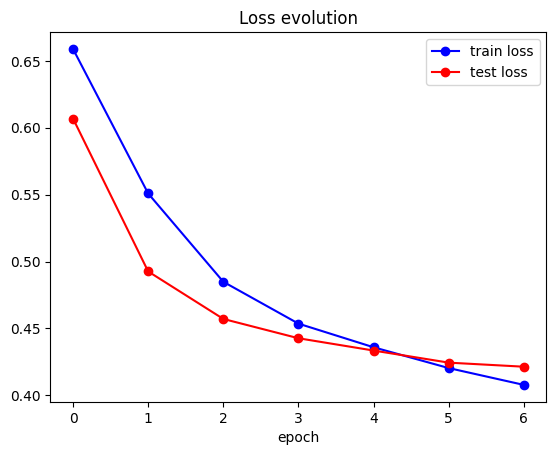

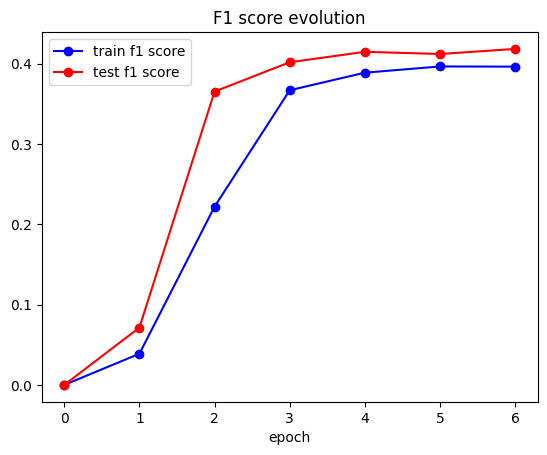

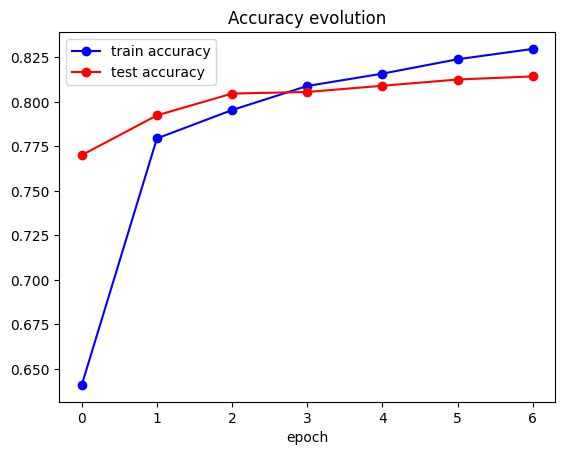

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acu = history.history['acc']
val_acu = history.history['val_acc']

f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

plt.figure()
plt.plot(history.epoch,loss, marker = 'o', color = 'b', label = "train loss")
plt.plot(history.epoch,val_loss, marker = 'o', color = 'r', label = "test loss")
plt.legend()
plt.title("Loss evolution")
plt.xlabel("epoch")
plt.savefig(model_path+"/loss.pdf")


plt.figure()
plt.plot(history.epoch,f1, marker = 'o', color = 'b', label = "train f1 score")
plt.plot(history.epoch,val_f1, marker = 'o', color = 'r', label = "test f1 score")
plt.legend()
plt.title("F1 score evolution")
plt.xlabel("epoch")
plt.savefig(model_path+"/f1_score.pdf")

plt.figure()
plt.plot(history.epoch,acu, marker = 'o', color = 'b', label = "train accuracy")
plt.plot(history.epoch,val_acu, marker = 'o', color = 'r', label = "test accuracy")
plt.legend()
plt.title("Accuracy evolution")
plt.xlabel("epoch")
plt.savefig(model_path+"/accuracy.pdf")

## Bucle para learning rate

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreT

modelo_5e-07
Epoch 1/10
167/167 - 49s - loss: 0.6913 - acc: 0.5341 - f1_score: 0.0000e+00 - val_loss: 0.6768 - val_acc: 0.6292 - val_f1_score: 0.0000e+00 - 49s/epoch - 293ms/step
Epoch 2/10
167/167 - 24s - loss: 0.6612 - acc: 0.6375 - f1_score: 0.0000e+00 - val_loss: 0.6433 - val_acc: 0.6891 - val_f1_score: 0.0000e+00 - 24s/epoch - 146ms/step
Epoch 3/10
167/167 - 25s - loss: 0.6116 - acc: 0.7262 - f1_score: 0.0000e+00 - val_loss: 0.5766 - val_acc: 0.7697 - val_f1_score: 0.0000e+00 - 25s/epoch - 147ms/step
Epoch 4/10
167/167 - 25s - loss: 0.5419 - acc: 0.7842 - f1_score: 0.0287 - val_loss: 0.5151 - val_acc: 0.7820 - val_f1_score: 0.0600 - 25s/epoch - 147ms/step
Epoch 5/10
167/167 - 24s - loss: 0.4923 - acc: 0.7990 - f1_score: 0.1235 - val_loss: 0.4819 - val_acc: 0.7881 - val_f1_score: 0.2474 - 24s/epoch - 146ms/step
Epoch 6/10
167/167 - 26s - loss: 0.4685 - acc: 0.8037 - f1_score: 0.2732 - val_loss: 0.4638 - val_acc: 0.7973 - val_f1_score: 0.3443 - 26s/epoch - 156ms/step
Epoch 7/10
167/

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreT

modelo_1e-06
Epoch 1/10
167/167 - 49s - loss: 0.6563 - acc: 0.6765 - f1_score: 0.0000e+00 - val_loss: 0.6139 - val_acc: 0.7820 - val_f1_score: 0.0000e+00 - 49s/epoch - 292ms/step
Epoch 2/10
167/167 - 25s - loss: 0.5717 - acc: 0.7898 - f1_score: 0.1482 - val_loss: 0.5273 - val_acc: 0.7898 - val_f1_score: 0.3632 - 25s/epoch - 150ms/step
Epoch 3/10
167/167 - 24s - loss: 0.5030 - acc: 0.8082 - f1_score: 0.3987 - val_loss: 0.4756 - val_acc: 0.8056 - val_f1_score: 0.4101 - 24s/epoch - 144ms/step
Epoch 4/10
167/167 - 24s - loss: 0.4579 - acc: 0.8170 - f1_score: 0.4072 - val_loss: 0.4448 - val_acc: 0.8122 - val_f1_score: 0.4080 - 24s/epoch - 146ms/step
Epoch 5/10
167/167 - 24s - loss: 0.4321 - acc: 0.8229 - f1_score: 0.4049 - val_loss: 0.4297 - val_acc: 0.8157 - val_f1_score: 0.4255 - 24s/epoch - 146ms/step
Epoch 6/10
167/167 - 25s - loss: 0.4103 - acc: 0.8307 - f1_score: 0.4154 - val_loss: 0.4210 - val_acc: 0.8165 - val_f1_score: 0.4297 - 25s/epoch - 147ms/step
Epoch 7/10
167/167 - 24s - loss

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreT

modelo_5e-06
Epoch 1/10
167/167 - 49s - loss: 0.5631 - acc: 0.7266 - f1_score: 0.2319 - val_loss: 0.4507 - val_acc: 0.8008 - val_f1_score: 0.4363 - 49s/epoch - 291ms/step
Epoch 2/10
167/167 - 25s - loss: 0.4242 - acc: 0.8189 - f1_score: 0.4147 - val_loss: 0.4120 - val_acc: 0.8192 - val_f1_score: 0.4360 - 25s/epoch - 150ms/step
Epoch 3/10
167/167 - 24s - loss: 0.3764 - acc: 0.8456 - f1_score: 0.4269 - val_loss: 0.4265 - val_acc: 0.8148 - val_f1_score: 0.4530 - 24s/epoch - 147ms/step
Epoch 4/10
167/167 - 25s - loss: 0.3470 - acc: 0.8617 - f1_score: 0.4281 - val_loss: 0.4108 - val_acc: 0.8240 - val_f1_score: 0.4444 - 25s/epoch - 148ms/step
Epoch 5/10
167/167 - 25s - loss: 0.3077 - acc: 0.8844 - f1_score: 0.4311 - val_loss: 0.4295 - val_acc: 0.8266 - val_f1_score: 0.4470 - 25s/epoch - 148ms/step
Epoch 6/10
167/167 - 26s - loss: 0.2802 - acc: 0.8959 - f1_score: 0.4371 - val_loss: 0.4292 - val_acc: 0.8222 - val_f1_score: 0.4431 - 26s/epoch - 157ms/step
Epoch 7/10
167/167 - 24s - loss: 0.2511

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreT

modelo_1e-06
Epoch 1/10
167/167 - 51s - loss: 0.6726 - acc: 0.6365 - f1_score: 0.0000e+00 - val_loss: 0.6390 - val_acc: 0.7579 - val_f1_score: 0.0000e+00 - 51s/epoch - 303ms/step
Epoch 2/10
167/167 - 25s - loss: 0.5695 - acc: 0.7801 - f1_score: 0.0353 - val_loss: 0.5057 - val_acc: 0.7811 - val_f1_score: 0.2034 - 25s/epoch - 150ms/step
Epoch 3/10
167/167 - 24s - loss: 0.4787 - acc: 0.7998 - f1_score: 0.3213 - val_loss: 0.4588 - val_acc: 0.7999 - val_f1_score: 0.3907 - 24s/epoch - 146ms/step
Epoch 4/10
167/167 - 24s - loss: 0.4462 - acc: 0.8069 - f1_score: 0.3879 - val_loss: 0.4407 - val_acc: 0.8104 - val_f1_score: 0.4099 - 24s/epoch - 146ms/step
Epoch 5/10
167/167 - 27s - loss: 0.4244 - acc: 0.8225 - f1_score: 0.4065 - val_loss: 0.4325 - val_acc: 0.8113 - val_f1_score: 0.4263 - 27s/epoch - 159ms/step
Epoch 6/10
167/167 - 26s - loss: 0.4134 - acc: 0.8262 - f1_score: 0.4107 - val_loss: 0.4256 - val_acc: 0.8148 - val_f1_score: 0.4227 - 26s/epoch - 158ms/step
Epoch 7/10
167/167 - 24s - loss

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreT

modelo_5e-06
Epoch 1/10
167/167 - 49s - loss: 0.5505 - acc: 0.7339 - f1_score: 0.2363 - val_loss: 0.4465 - val_acc: 0.8017 - val_f1_score: 0.4324 - 49s/epoch - 295ms/step
Epoch 2/10
167/167 - 25s - loss: 0.4215 - acc: 0.8255 - f1_score: 0.4114 - val_loss: 0.4099 - val_acc: 0.8240 - val_f1_score: 0.4228 - 25s/epoch - 152ms/step
Epoch 3/10
167/167 - 25s - loss: 0.3769 - acc: 0.8474 - f1_score: 0.4152 - val_loss: 0.4141 - val_acc: 0.8165 - val_f1_score: 0.4430 - 25s/epoch - 148ms/step
Epoch 4/10
167/167 - 25s - loss: 0.3452 - acc: 0.8655 - f1_score: 0.4225 - val_loss: 0.4176 - val_acc: 0.8214 - val_f1_score: 0.4479 - 25s/epoch - 149ms/step
Epoch 5/10
167/167 - 26s - loss: 0.3115 - acc: 0.8788 - f1_score: 0.4301 - val_loss: 0.4238 - val_acc: 0.8275 - val_f1_score: 0.4454 - 26s/epoch - 158ms/step
Epoch 6/10
167/167 - 26s - loss: 0.2727 - acc: 0.9002 - f1_score: 0.4352 - val_loss: 0.4245 - val_acc: 0.8301 - val_f1_score: 0.4425 - 26s/epoch - 156ms/step
Epoch 7/10
167/167 - 24s - loss: 0.2492

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreT

modelo_1e-05
Epoch 1/10
167/167 - 50s - loss: 0.5038 - acc: 0.7662 - f1_score: 0.3271 - val_loss: 0.4141 - val_acc: 0.8170 - val_f1_score: 0.4078 - 50s/epoch - 302ms/step
Epoch 2/10
167/167 - 25s - loss: 0.3828 - acc: 0.8414 - f1_score: 0.4148 - val_loss: 0.3992 - val_acc: 0.8253 - val_f1_score: 0.4230 - 25s/epoch - 150ms/step
Epoch 3/10
167/167 - 24s - loss: 0.3252 - acc: 0.8731 - f1_score: 0.4276 - val_loss: 0.4099 - val_acc: 0.8332 - val_f1_score: 0.4384 - 24s/epoch - 146ms/step
Epoch 4/10
167/167 - 25s - loss: 0.2725 - acc: 0.8972 - f1_score: 0.4343 - val_loss: 0.4567 - val_acc: 0.8187 - val_f1_score: 0.4444 - 25s/epoch - 148ms/step
Epoch 5/10
167/167 - 24s - loss: 0.2212 - acc: 0.9223 - f1_score: 0.4414 - val_loss: 0.4573 - val_acc: 0.8253 - val_f1_score: 0.4361 - 24s/epoch - 146ms/step
Epoch 6/10
167/167 - 24s - loss: 0.1799 - acc: 0.9394 - f1_score: 0.4436 - val_loss: 0.5411 - val_acc: 0.8174 - val_f1_score: 0.4515 - 24s/epoch - 146ms/step
Epoch 7/10
167/167 - 24s - loss: 0.1508

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreT

modelo_5e-05
Epoch 1/10
167/167 - 49s - loss: 0.4650 - acc: 0.7885 - f1_score: 0.3629 - val_loss: 0.3913 - val_acc: 0.8244 - val_f1_score: 0.4117 - 49s/epoch - 291ms/step
Epoch 2/10
167/167 - 25s - loss: 0.3325 - acc: 0.8643 - f1_score: 0.4095 - val_loss: 0.4149 - val_acc: 0.8205 - val_f1_score: 0.4090 - 25s/epoch - 150ms/step
Epoch 3/10
167/167 - 24s - loss: 0.2255 - acc: 0.9135 - f1_score: 0.4283 - val_loss: 0.4525 - val_acc: 0.8165 - val_f1_score: 0.4135 - 24s/epoch - 146ms/step
Epoch 4/10
167/167 - 24s - loss: 0.1495 - acc: 0.9467 - f1_score: 0.4392 - val_loss: 0.6171 - val_acc: 0.8056 - val_f1_score: 0.4584 - 24s/epoch - 146ms/step
Epoch 5/10
167/167 - 24s - loss: 0.0946 - acc: 0.9640 - f1_score: 0.4474 - val_loss: 0.6529 - val_acc: 0.7868 - val_f1_score: 0.4509 - 24s/epoch - 146ms/step
Epoch 6/10
167/167 - 24s - loss: 0.0878 - acc: 0.9638 - f1_score: 0.4435 - val_loss: 0.7597 - val_acc: 0.8021 - val_f1_score: 0.4560 - 24s/epoch - 145ms/step
Epoch 7/10
167/167 - 24s - loss: 0.0711

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreT

modelo_0.0001
Epoch 1/10
167/167 - 51s - loss: 0.4746 - acc: 0.7844 - f1_score: 0.3714 - val_loss: 0.4187 - val_acc: 0.8227 - val_f1_score: 0.3930 - 51s/epoch - 304ms/step
Epoch 2/10
167/167 - 25s - loss: 0.3241 - acc: 0.8726 - f1_score: 0.4199 - val_loss: 0.4390 - val_acc: 0.8257 - val_f1_score: 0.4322 - 25s/epoch - 152ms/step
Epoch 3/10
167/167 - 24s - loss: 0.2170 - acc: 0.9236 - f1_score: 0.4357 - val_loss: 0.5266 - val_acc: 0.8008 - val_f1_score: 0.4509 - 24s/epoch - 146ms/step
Epoch 4/10
167/167 - 24s - loss: 0.1433 - acc: 0.9475 - f1_score: 0.4462 - val_loss: 0.6084 - val_acc: 0.7877 - val_f1_score: 0.4524 - 24s/epoch - 145ms/step
Epoch 5/10
167/167 - 24s - loss: 0.0926 - acc: 0.9668 - f1_score: 0.4474 - val_loss: 0.6735 - val_acc: 0.7877 - val_f1_score: 0.4579 - 24s/epoch - 147ms/step
Epoch 6/10
167/167 - 24s - loss: 0.1009 - acc: 0.9625 - f1_score: 0.4467 - val_loss: 0.8606 - val_acc: 0.8030 - val_f1_score: 0.4570 - 24s/epoch - 146ms/step
Epoch 7/10
167/167 - 25s - loss: 0.071

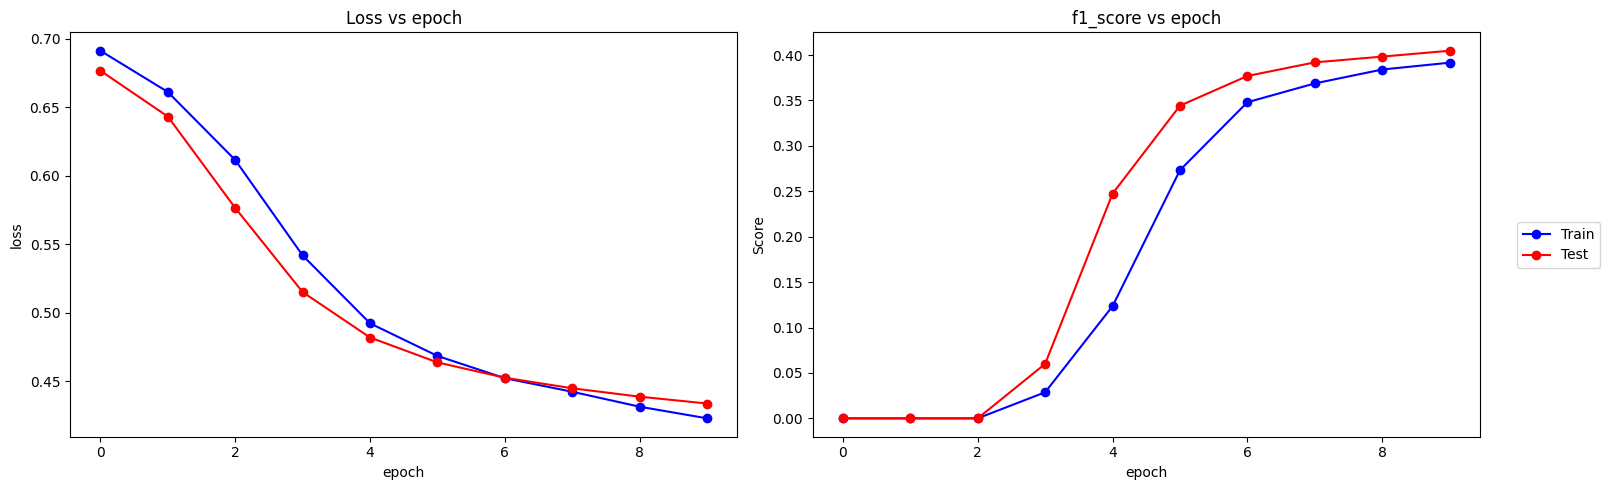

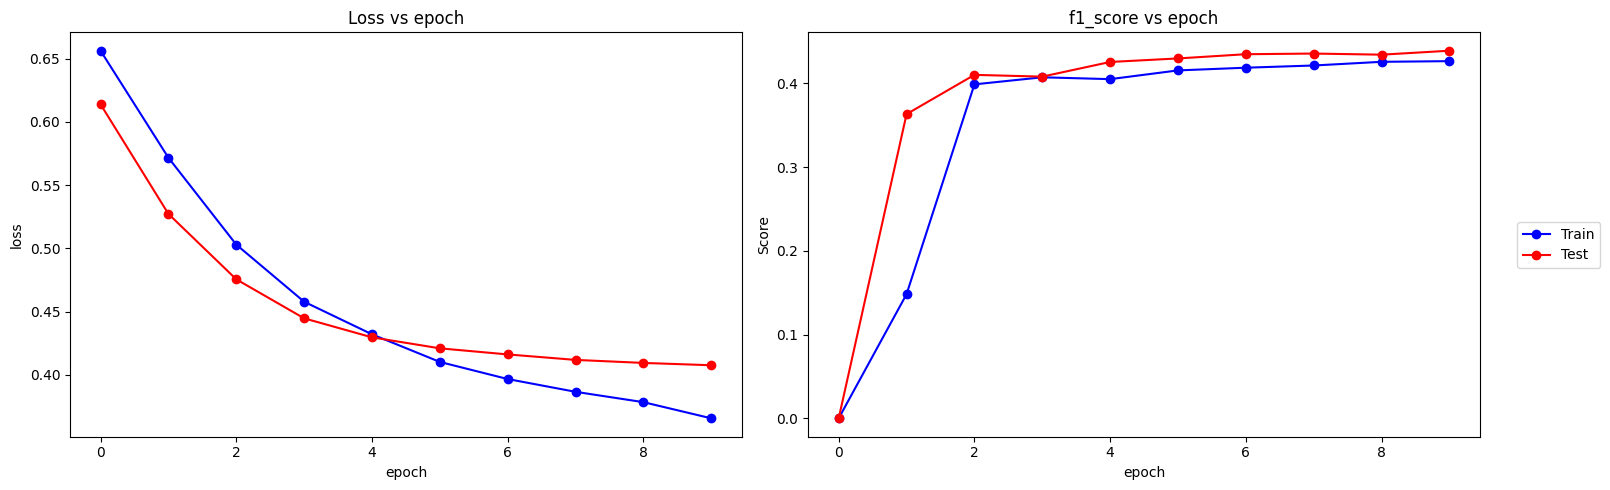

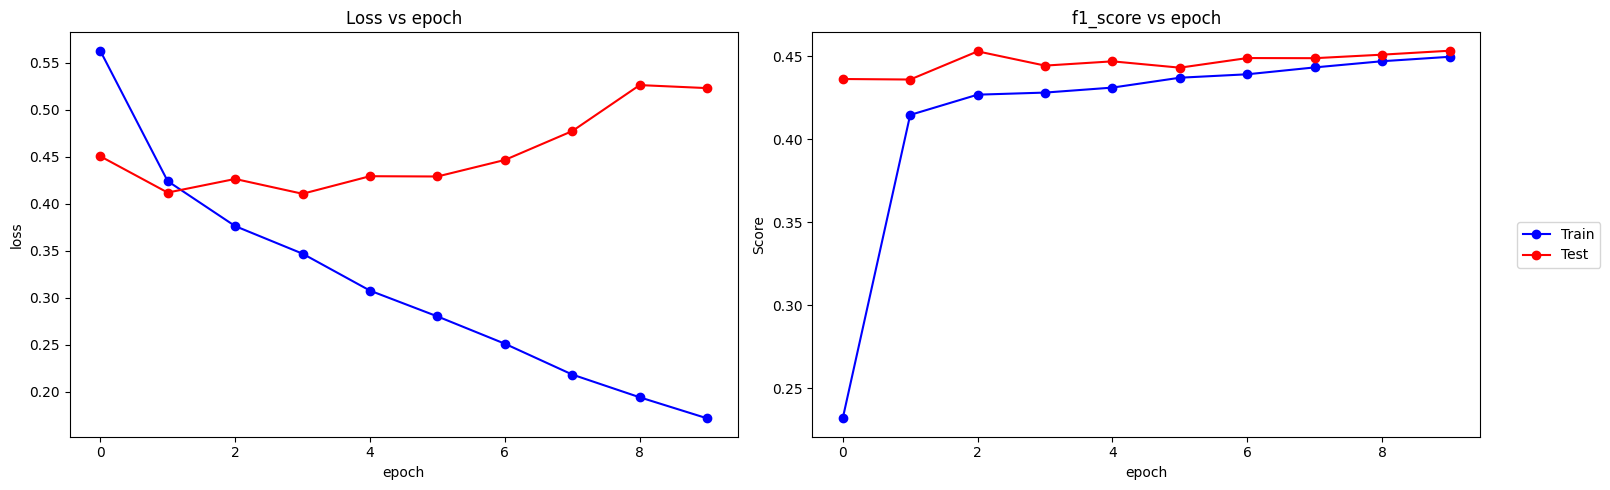

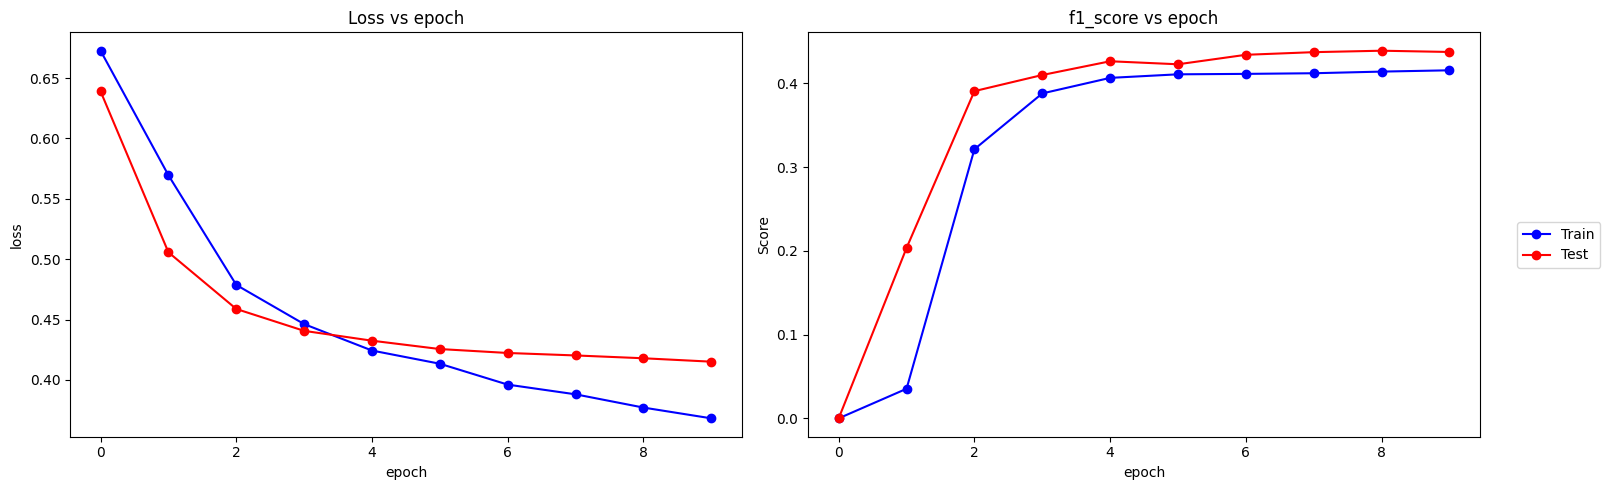

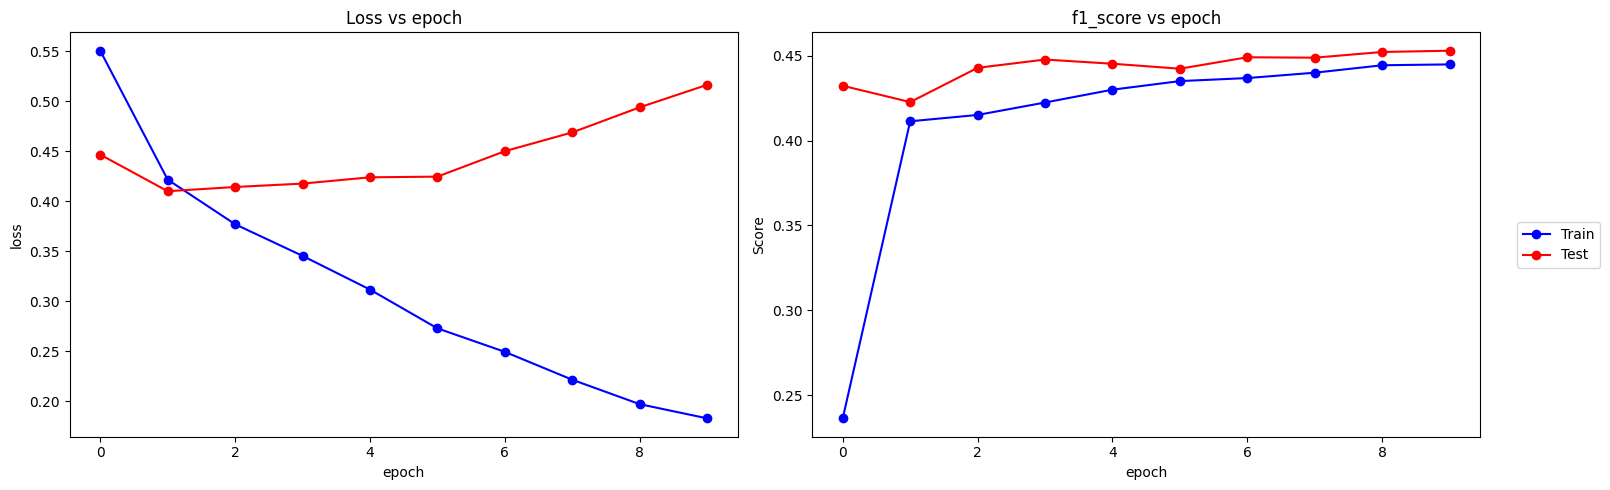

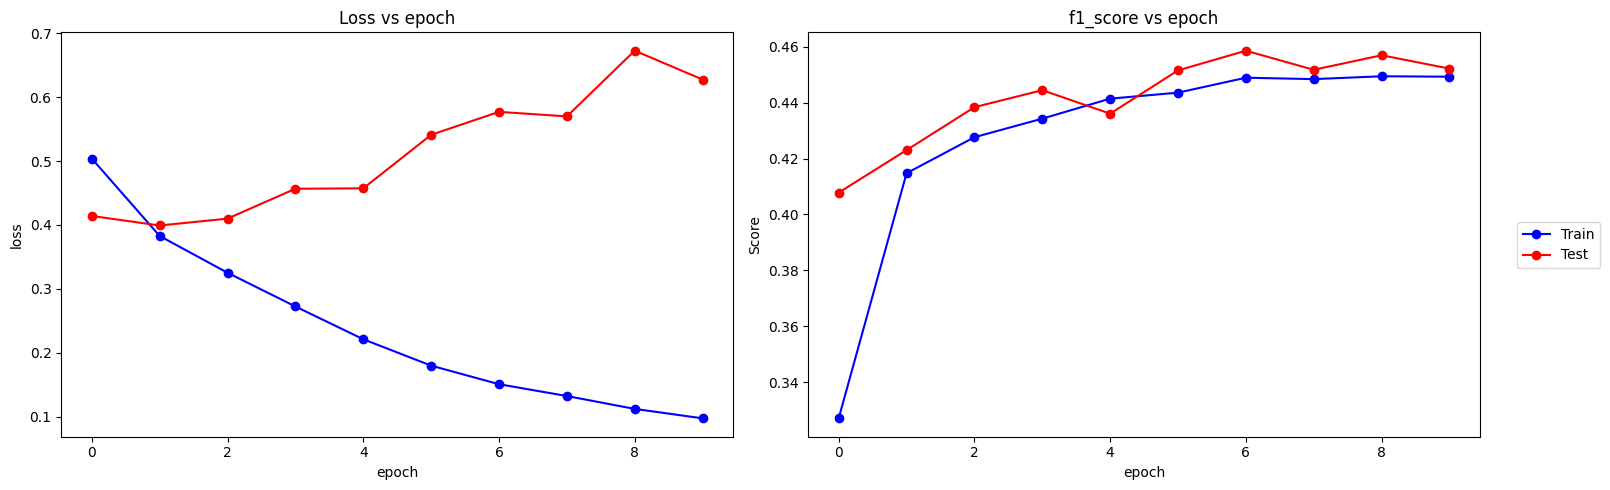

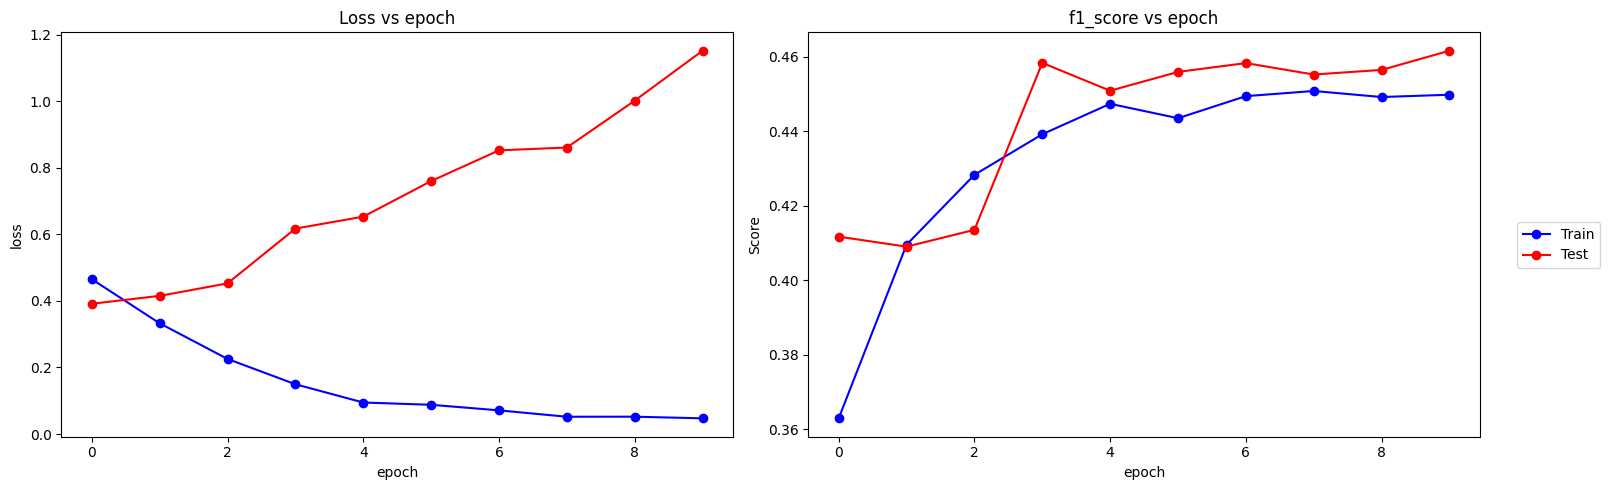

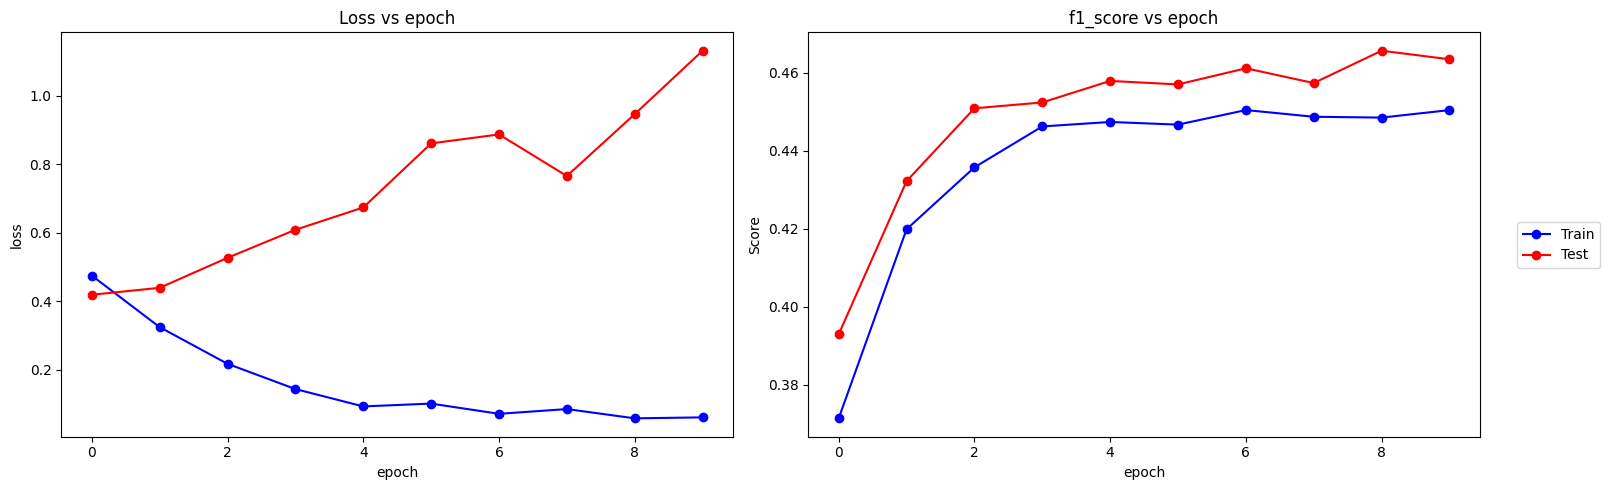

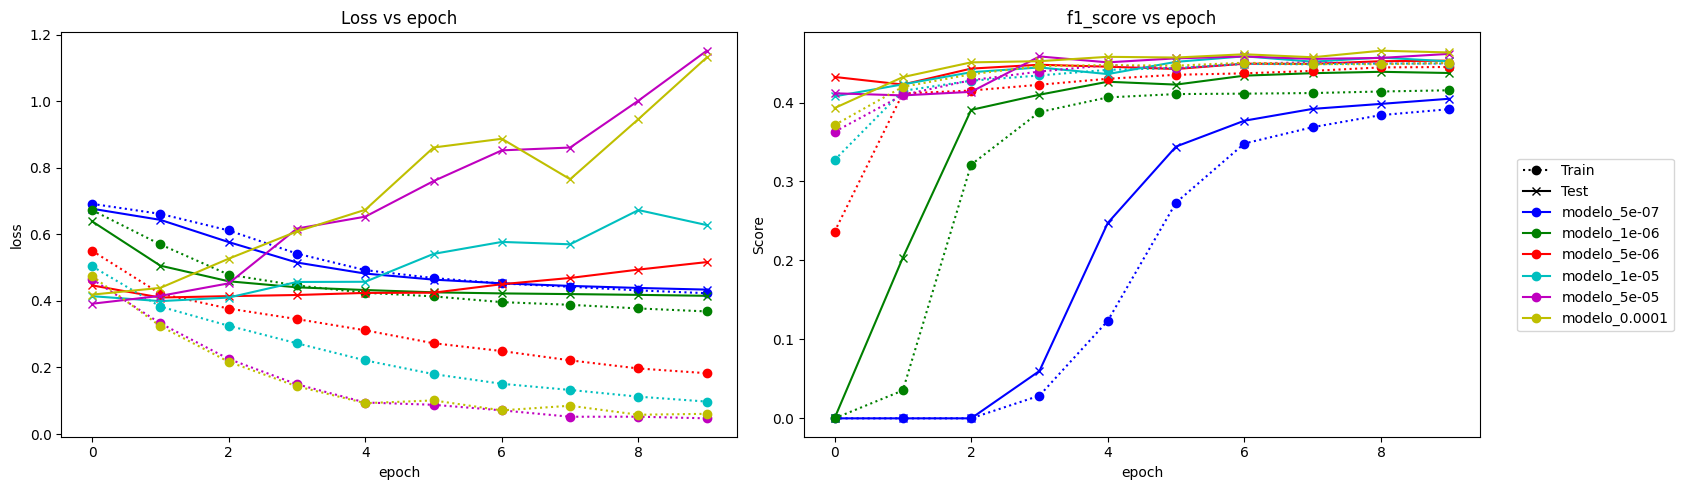

In [ ]:
learning_rates = [5e-7,1e-6,5e-6,1e-6,5e-6,1e-5,5e-5,1e-4]


todos_los_resultados = {}

for lr in learning_rates:
  epochs = 10
  # Load the pre-trained model
  model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
  model_path = f"modelo_{lr}"
  print(model_path)
  # Compile the model
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric_accu = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  #metric_f1 = tf.keras.metrics.F1Score() # No va

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['acc',tf.keras.metrics.F1Score(average="micro", threshold=0.5 )])

  # Train the model

  history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose = 2)

  # Save the model
  model.save_pretrained(model_path)

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acu = history.history['f1_score']
  val_acu = history.history['val_f1_score']

  resultados = {'epochs': history.epoch,
                'loss':history.history['loss'],
                'f1_score': history.history['f1_score'],
                'val_loss':history.history['val_loss'],
                'val_f1_score': history.history['val_f1_score']
                }
  pd.DataFrame(resultados).to_csv(model_path+"/results.csv",index =False)
  todos_los_resultados[model_path] = pd.DataFrame(resultados)

  fig, axes = plt.subplots(1, 2,figsize=(15, 5))
  axes[0].set_xlabel('epoch')
  axes[0].set_ylabel('loss')
  axes[0].set_title(f'Loss vs epoch')
  axes[1].set_xlabel('epoch')
  axes[1].set_ylabel('Score')
  axes[1].set_title(f'f1_score vs epoch')
  axes[0].plot(history.epoch, loss, color='b',linestyle='solid', marker='o',label = "Train")
  axes[0].plot(history.epoch, val_loss, color='r',linestyle='solid', marker='o', label = "Test")
  axes[1].plot(history.epoch, acu, color='b',linestyle='solid', marker='o')
  axes[1].plot(history.epoch, val_acu, color='r',linestyle='solid', marker='o')

  fig.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1)
  plt.tight_layout()
  plt.savefig(model_path+"/figure.pdf", bbox_inches='tight')

# Plot de todo

fig, axes = plt.subplots(1, 2,figsize=(15, 5))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
first = True
i = 0
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].set_title(f'Loss vs epoch')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('Score')
axes[1].set_title(f'f1_score vs epoch')
axes[0].plot(np.nan,np.nan, color="black",linestyle='dotted',marker='o',label = "Train")
axes[0].plot(np.nan,np.nan, color="black",linestyle='solid',marker='x',label = "Test")
for modelo,df in todos_los_resultados.items():
  c = colors[i]
  i+=1

  axes[0].plot(df['epochs'], df['loss'], color=c,linestyle='dotted', marker='o')
  axes[0].plot(df['epochs'], df['val_loss'], color=c,linestyle='solid', marker='x')
  axes[1].plot(df['epochs'], df['f1_score'], color=c,linestyle='dotted', marker='o')
  axes[1].plot(df['epochs'], df['val_f1_score'], color=c,linestyle='solid', marker='x')
  axes[0].plot(np.nan,np.nan, color=c,marker='o',label = modelo)



fig.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1)
plt.tight_layout()
plt.savefig('todo.pdf', bbox_inches='tight')


## Submission

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained("modelo")

Some layers from the model checkpoint at modelo2 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at modelo2 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sentences = list(test_df['text'])
sentences = [' '.join(texto) for texto in CleanTokenize(test_df,'text')]
sentences_tokenized = tokenizer(sentences, padding=True, truncation=True, return_tensors='tf', max_length = 128)


predictions = model.predict(dict(sentences_tokenized))

102/102 [==============================] - 7s 48ms/step


In [ ]:
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy();predicted_labels


submission_df = pd.DataFrame()
submission_df['id'] = test_df['id']
submission_df['target'] = predicted_labels

submission_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
submission_df.to_csv('kaggle_submission.csv', index=False)

In [ ]:
!mkdir ~/.kaggle    #make a dir
!cp kaggle.json ~/.kaggle/   #cp file
!chmod 600 ~/.kaggle/kaggle.json #change permisssions
!ls ~/ -a #list all dirs in ~/

!kaggle competitions submit -c nlp-getting-started -f kaggle_submission.csv -m "2 epochs 2e-5"

.   .bashrc  .config   .jupyter  .keras		.local	   .npm  .profile    .wget-hsts
..  .cache   .ipython  .kaggle	 .launchpadlib	nltk_data  .nv	 .tmux.conf
100% 22.2k/22.2k [00:02<00:00, 9.87kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

epochs = 2

0.83052